In [455]:
import numpy as np
from numpy import eye, array, asarray
from numpy.linalg import inv
from numpy.random import randn
import math
from math import sqrt
import matplotlib.pyplot as plt

In [456]:
class KalmanFilter:
    def __init__(self):
        self.M = None
        self.H = None
        self.mu = None
        self.Sigma = None
        self.Sigma_y = None
        self.Q = None
        
    def predict_response(self):
        return self.H @ self.mu
    
    # KF assimilation
    def update(self, y_t):
        # Predict y to measure innovation
        y_hat = self.predict_response()
        # Calculate Kalman gain
        K = self.Sigma @ self.H.T @ inv(self.H @ self.Sigma @ self.H.T + self.Sigma_y)
        # Update belief
        I = np.eye(self.mu.size)
        h_tmp = (y_t - y_hat)        
        self.mu = self.mu + K @ (y_t - y_hat)
        self.Sigma = (I-K@self.H)@self.Sigma
    
    # time dynamics
    def predict(self):
        self.mu = self.M @ self.mu
        self.Sigma = self.M @ self.Sigma @ self.M.T + self.Q

*Ensemble Kalman Filteret* blir relevant når tids-dynamikkar er svært ikkje-lineære og Jacobianen ikkje kan reknast analytisk, numerisk, eller med bruk av automatisk differensiering.

\begin{align}
\mathbf{x}_{t|t-1} &= m(\mathbf{x}_{t-1|t-1})\\
\hat{\mathbf{y}}_{t} &= h(\mathbf{x}_{t|t-1})
\end{align}

In [457]:
class EnsembleKalmanFilter(KalmanFilter):
    def __init__(self, N, mu, Sigma, EnsembleElementClass):
        super().__init__()
        self.m = None
        self.N = N
        self.mu = mu
        self.Sigma = Sigma
        self.EnsembleElementClass = EnsembleElementClass # must have from_state classmethod returning instance and update_state method
        self.ensemble = self.sample_ensemble()
    
    def sample_ensemble(self):
        parameter_sample = np.random.multivariate_normal(self.mu.ravel(), self.Sigma, self.N)
        return [self.EnsembleElementClass.from_state(x) for x in parameter_sample]
    
    def update_ensemble(self):
        parameter_sample = np.random.multivariate_normal(self.mu.ravel(), self.Sigma, self.N)
        for i in range(self.N):
            self.ensemble[i].update_state(parameter_sample[i])
    
    def update(self, y_t):
        super().update(y_t)
        self.update_ensemble()
        
    def predict(self):
        for i in range(self.N):
            self.ensemble[i].run_dynamics()
        states = array([sample.state() for sample in self.ensemble])
        self.mu = array(states.mean(axis=0)).T
        self.mu.shape = (self.mu.size,1)
        self.Sigma = np.cov(states, rowvar=False)
        
        

In [458]:
class DrunkDrivingDynamics:
    def __init__(self, p, v):
        self.p0 = p
        self.p = p
        self.v0 = v
        self.v = v
        self.t0 = 0
        self.t = 0
        
    @classmethod
    def from_state(cls, x):
        return cls(x[0], x[1])
    
    def run_dynamics(self, dt=1.0):
        # Drunk person desides to speed up to root of pos^2 and v^2 until next time
        self.t = self.t+dt
        self.v = np.sqrt(self.v**2 + self.p**2)
        self.p = self.p + dt*self.t
        
        #self.t = self.t+dt
        #Dt = self.t-self.t0
        #self.v = np.sin(self.t) + self.v0 # drunk velocity
        #self.p = self.p0 + (-np.cos(self.t) - -(np.cos(self.t0))) + Dt*self.v0 # p = p0 + int_t0^t v(s) ds
    
    def update_state(self, x):
        self.p = x[0]
        self.v = x[1]
        #self.v0 = self.v - np.sin(self.t)
        #self.p0 = self.p - (-np.cos(self.t) - -(np.cos(self.t0))) + (self.t-self.t0)*self.v0 
    
    def shouts_out_his_position(self, var_y, dt=1.0):
        self.run_dynamics(dt)
        err = np.random.normal(0, np.sqrt(var_y), 1)
        return self.p + err
    
    def state(self):
        return array([self.p, self.v])

In [459]:
# Initialize the drunk driver
drunk = DrunkDrivingDynamics(1, 0.5)

# Initialize the Kalman Filter
enkf = EnsembleKalmanFilter(
    N=1000,
    mu=array([[20],
              [0]]),
    Sigma=array([[100,0],
                 [0,100]]),
    EnsembleElementClass = DrunkDrivingDynamics,
)
# predict dynamics
dt = 1
enkf.Q = eye(2)*0
# update dynamics
enkf.H = array([
    [1,0]
])

In [460]:
# Assimilate over time
T=30
#xs = []
time = []
xs_prior = []
xs_posterior = []
track = []
drunk_belief = []
for t in range(T):
    enkf.Sigma_y = 10* enkf.mu[0]
    time.append(t)
    y = drunk.shouts_out_his_position(var_y=enkf.Sigma_y)
    xs_prior.append(enkf.mu)
    drunk_belief.append(y)
    track.append((drunk.p, drunk.v))
    enkf.update(array([y]))
    xs_posterior.append(enkf.mu)
    xs.append(enkf.mu)
    enkf.predict()
 

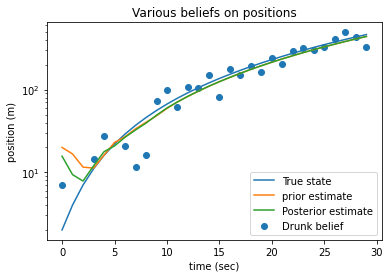

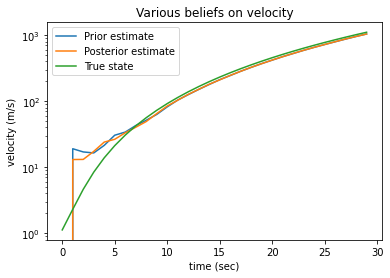

In [461]:
# Inspect
pos_prior = [x[0] for x in xs_prior]
pos_posterior = [x[0] for x in xs_posterior]
track = asarray(track)
plot1 = plt.figure(1)
plt.plot(time, track[:,0])
plt.plot(time, pos_prior)
plt.plot(time, pos_posterior)
plt.scatter(time, drunk_belief)
plt.yscale('log')
plt.title("Various beliefs on positions")
plt.ylabel("position (m)")
plt.xlabel("time (sec)")
plt.legend(["True state", "prior estimate", 'Posterior estimate', "Drunk belief"])
plt.show()

vel_prior = [x[1] for x in xs_prior]
vel_posterior = [x[1] for x in xs_posterior]
plot2 = plt.figure(2)
plt.plot(time, vel_prior)
plt.plot(time, vel_posterior)
plt.plot(time, track[:,1])
plt.yscale('log')
plt.title("Various beliefs on velocity")
plt.ylabel("velocity (m/s)")
plt.xlabel("time (sec)")
plt.legend(["Prior estimate", 'Posterior estimate', "True state"])
plt.show()